Proyek Klasifikasi Gambar: rice-image-dataset
*   Nama : Alhan Husen
*   Email : alhannhusein@gmail.com

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style('darkgrid')
import itertools

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation,Dropout
from keras.models import Model, Sequential
from keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix,classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import imageio
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as img

import os
import pathlib

import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.applications import imagenet_utils


In [ ]:
pip install tensorflowjs

In [ ]:
import kagglehub
import os

path = kagglehub.dataset_download("muratkokludataset/rice-image-dataset")

print("Dataset sudah tersedia di path:", path)
print("Anda bisa langsung menggunakan path ini untuk melatih model.")

try:
    arborio_path = os.path.join(path, 'Arborio')
    print("\nContoh 5 file di dalam folder Arborio:")
    print(os.listdir(arborio_path)[:5])
except FileNotFoundError:
    print(f"\nIsi dari direktori utama '{path}':")
    print(os.listdir(path))

Dataset sudah tersedia di path: /kaggle/input/rice-image-dataset
Anda bisa langsung menggunakan path ini untuk melatih model.

Contoh 5 file di dalam folder Arborio:

Isi dari direktori utama '/kaggle/input/rice-image-dataset':
['Rice_Image_Dataset']


In [ ]:
import pathlib

# Corrected dataset_path to point to the actual download location
dataset_path = "/kaggle/input/rice-image-dataset/Rice_Image_Dataset"

# Convert dataset_path to a Path object
dataset_path = pathlib.Path(dataset_path)

arborio = list(dataset_path.glob('Arborio/*'))[:1000]
basmati = list(dataset_path.glob('Basmati/*'))[:1000]
ipsala = list(dataset_path.glob('Ipsala/*'))[:1000]
jasmine = list(dataset_path.glob('Jasmine/*'))[:1000]
karacadag = list(dataset_path.glob('Karacadag/*'))[:1000]

In [ ]:
data = {
    'arborio' : arborio,
    'basmati' : basmati,
    'ipsala' : ipsala,
    'jasmine' : jasmine,
    'karacadag': karacadag
}
rice_labels= {
    0: "Arborio",
    1: "Basmati",
    2: "Ipsala",
    3:"Jasmine",
    4:"Karacadag"}

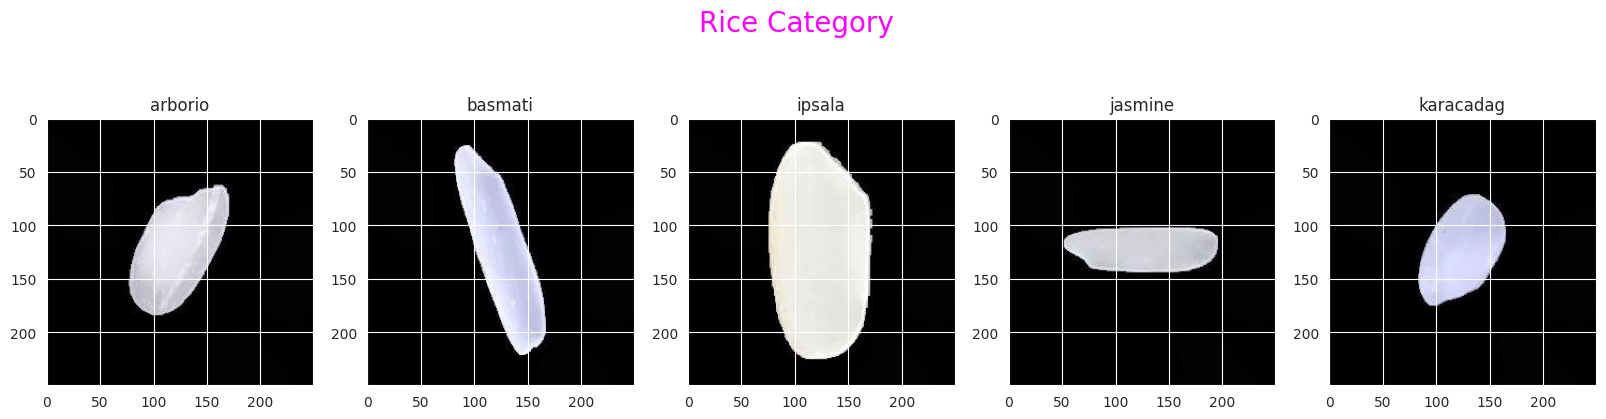

In [ ]:
fig, ax = plt.subplots(ncols=5, figsize=(20,5))
fig.suptitle('Rice Category',color='magenta',fontsize=20)
arborio_img = img.imread(arborio[0])
basmati_img = img.imread(basmati[0])
ipsala_img = img.imread(ipsala[0])
jasmine_img = img.imread(jasmine[0])
karacadag_img = img.imread(karacadag[0])

for index,name in enumerate(list(data.keys())):
    ax[index].set_title(name)
ax[0].imshow(arborio_img)
ax[1].imshow(basmati_img)
ax[2].imshow(ipsala_img)
ax[3].imshow(jasmine_img)
ax[4].imshow(karacadag_img)

In [ ]:
# Buat list semua file gambar beserta label-nya
filepaths = []
labels = []

for label in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, label)
    if os.path.isdir(class_dir):
        for file in os.listdir(class_dir):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                filepaths.append(os.path.join(class_dir, file))
                labels.append(label)

# Buat dataframe
df = pd.DataFrame({
    'filename': filepaths,
    'class': labels
})

# Split train (70%) dan temp (30%)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['class'], random_state=42)

# Split temp jadi val (15%) dan test (15%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['class'], random_state=42)

print("Train:", len(train_df), "Validation:", len(val_df), "Test:", len(test_df))



Train: 52500 Validation: 11250 Test: 11250


In [ ]:
# Buat ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

# Buat generator dari dataframe
train_gen = datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

test_gen = datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 52500 validated image filenames belonging to 5 classes.
Found 11250 validated image filenames belonging to 5 classes.
Found 11250 validated image filenames belonging to 5 classes.


In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Load dan flatten gambar dari dataframe
def load_images(df, size=(32, 32)):
    images = []
    labels = []
    for _, row in df.iterrows():
        img = image.load_img(row['filename'], target_size=size)
        img_array = image.img_to_array(img) / 255.0
        images.append(img_array.flatten())
        labels.append(row['class'])
    return np.array(images), np.array(labels)

X_train, y_train = load_images(train_df)
X_val, y_val = load_images(val_df)
X_test, y_test = load_images(test_df)

In [ ]:
# Encode label
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

In [ ]:
# Train SVM
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train_enc)

SVC(kernel='linear', probability=True)


Classification Report:
              precision    recall  f1-score   support

     Arborio       0.98      0.99      0.99      2250
     Basmati       0.99      0.99      0.99      2250
      Ipsala       1.00      1.00      1.00      2250
     Jasmine       0.99      0.99      0.99      2250
   Karacadag       0.99      0.99      0.99      2250

    accuracy                           0.99     11250
   macro avg       0.99      0.99      0.99     11250
weighted avg       0.99      0.99      0.99     11250



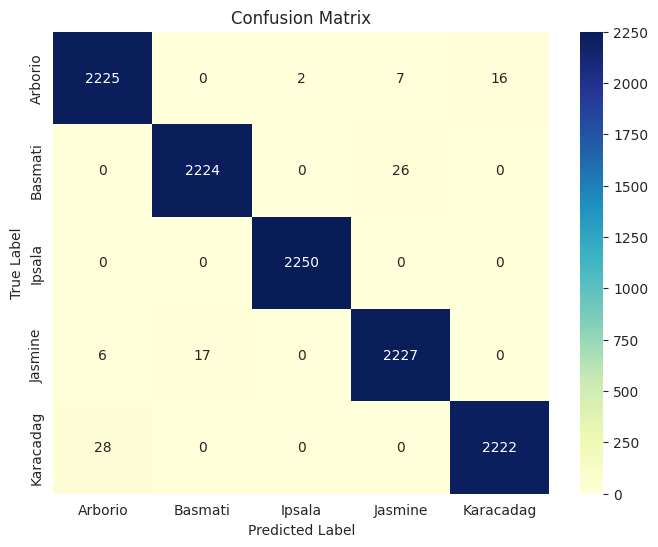

In [ ]:
# Evaluasi dan visualisasi
y_pred = svm_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

# Confusion Matrix (heatmap)
cm = confusion_matrix(y_test_enc, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# ROC Curve (multi-class)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [ ]:
# Binarisasi label (multi-class → one-hot)
y_test_bin = label_binarize(y_test_enc, classes=np.arange(len(le.classes_)))
y_score = svm_model.decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(le.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

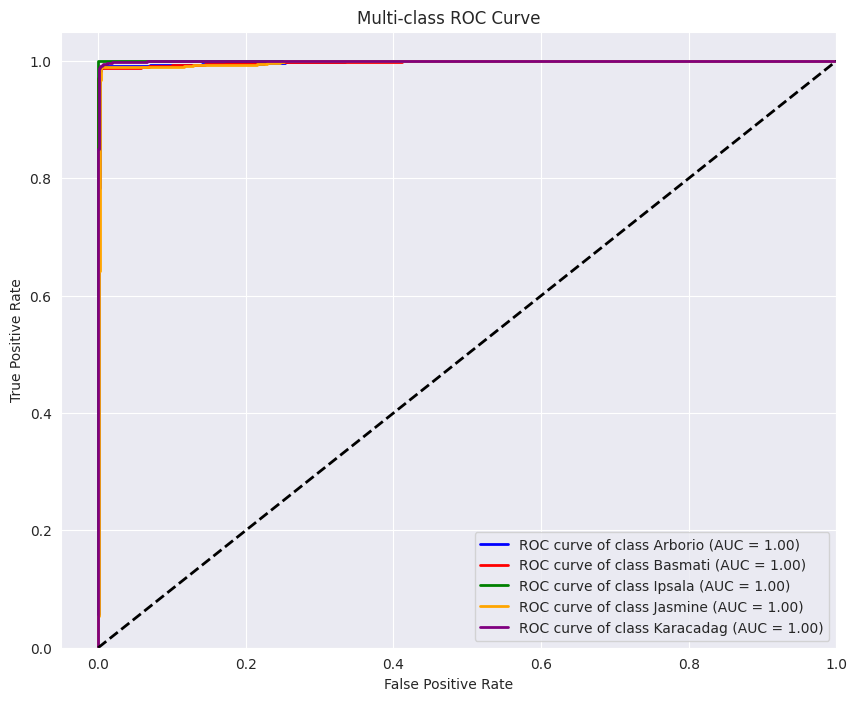

In [ ]:
# Plot semua ROC curve
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple']
for i, color in zip(range(len(le.classes_)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"ROC curve of class {le.classes_[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score

precision = dict()
recall = dict()
average_precision = dict()

for i in range(len(le.classes_)):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

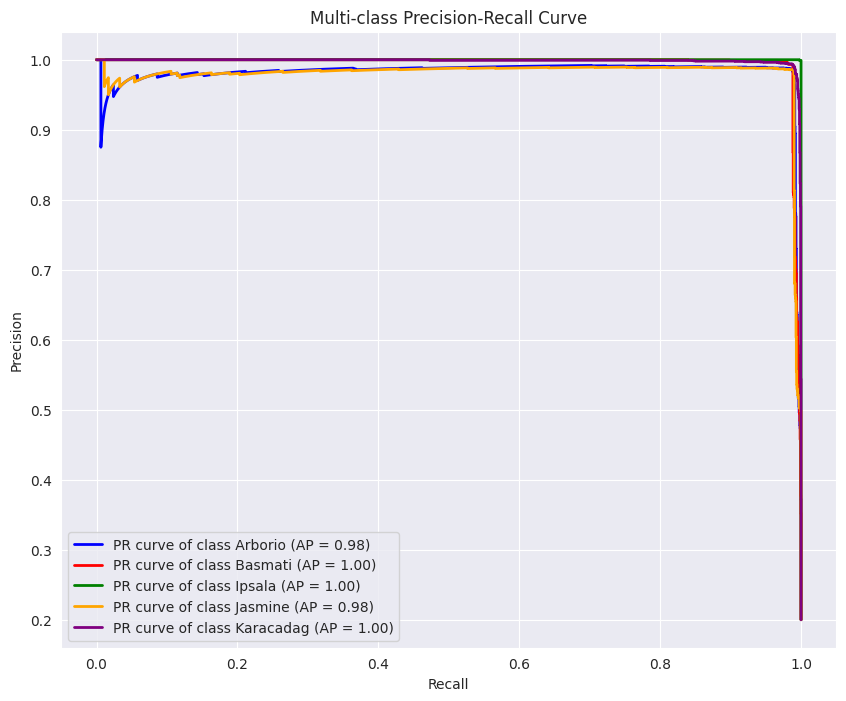

In [ ]:
# Plot semua Precision-Recall curve
plt.figure(figsize=(10, 8))
for i, color in zip(range(len(le.classes_)), colors):
    plt.plot(recall[i], precision[i], lw=2, color=color,
             label=f"PR curve of class {le.classes_[i]} (AP = {average_precision[i]:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Multi-class Precision-Recall Curve")
plt.legend(loc="best")
plt.grid(True)
plt.show()